In [1]:
# Importing TensorFlow and IMDb dataset from keras library
from keras.datasets import imdb
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Checking TensorFlow version
print(tf.__version__)

1.3.0


In [3]:
from __future__ import print_function

In [4]:
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Creating Train and Test datasets from labeled movie reviews 
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb_full.pkl",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [6]:
t = [item for sublist in X_train for item in sublist]
vocabulary = len(set(t))+1  

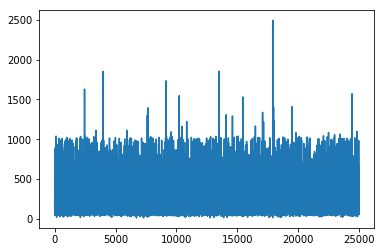

In [7]:
a = [len(x) for x in X_train]
plt.plot(a)

In [8]:
max_length = 200 # specifying the max length of the sequence in the sentence
x_filter = []
y_filter = []

# if the selected length is lesser than the specified max_length, 200, then appending padding (0), else only selecting
#       desired length only from sentence
for i in range(len(X_train)):
    if len(X_train[i])<max_length:
        a = len(X_train[i])
        X_train[i] = X_train[i] + [0] * (max_length - a)
        x_filter.append(X_train[i])
        y_filter.append(y_train[i])
    elif len(X_train[i])>max_length:
        X_train[i] = X_train[i][0:max_length]


In [9]:
#declaring the hyper params
embedding_size = 100   # word vector size for initializing the word embeddings
n_hidden = 200
learning_rate = 0.06
training_iters = 100000
batch_size = 32
beta =0.0001

In [10]:
n_steps = max_length #timestepswords
n_classes = 2 # 0/1 : binary classification for negative and positive reviews
da = 350    #hyper-parameter : Self-attention MLP has hidden layer with da units
r = 30      # count of different parts to be extracted from sentence (= # rows in matrix embedding)
display_step =10 
hidden_units = 3000

In [11]:
y_train = np.asarray(pd.get_dummies(y_filter))
X_train = np.asarray([np.asarray(g) for g in x_filter])

In [12]:
logs_path = './recent_logs/'

In [13]:
class DataIterator:
    def __init__(self, data1,data2, batch_size):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = self.make_random_iter()
        
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X =[self.data1[i] for i in idxs]
        Y =[self.data2[i] for i in idxs]
        
        X = np.array(X)
        Y = np.array(Y)
        return X, Y

    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data1), self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))), splits)[:-1]
        return iter(it)


In [14]:
############ Graph Creation ################      

# TF Graph Input
with tf.name_scope("weights"):
     Win  = tf.Variable(tf.random_uniform([n_hidden*r, hidden_units],-1/np.sqrt(n_hidden),1/np.sqrt(n_hidden)), name='W-input')
     Wout = tf.Variable(tf.random_uniform([hidden_units, n_classes],-1/np.sqrt(hidden_units),1/np.sqrt(hidden_units)), name='W-out')
     Ws1  = tf.Variable(tf.random_uniform([da,n_hidden],-1/np.sqrt(da),1/np.sqrt(da)), name='Ws1')
     Ws2  = tf.Variable(tf.random_uniform([r,da],-1/np.sqrt(r),1/np.sqrt(r)), name='Ws2')

In [15]:
with tf.name_scope("biases"):            
    biasesout = tf.Variable(tf.random_normal([n_classes]), name='biases-out')
    biasesin  = tf.Variable(tf.random_normal([hidden_units]), name='biases-in')

In [16]:
with tf.name_scope('input'):
    x = tf.placeholder("int32", [32,max_length], name='x-input')
    y = tf.placeholder("int32", [32, 2], name='y-input')


In [17]:
with tf.name_scope('embedding'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary, embedding_size],-1, 1), name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings,x)


In [18]:

def length(sequence):
    # Computing maximum of elements across dimensions of a tensor
    used = tf.sign(tf.reduce_max(tf.abs(sequence), reduction_indices=2))   
    
    length = tf.reduce_sum(used, reduction_indices=1)
    length = tf.cast(length, tf.int32)
    return length

In [19]:
with tf.variable_scope('forward',reuse=True):
        lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden)

In [20]:
with tf.name_scope('model'):  
    outputs, states = rnn.dynamic_rnn(lstm_fw_cell,embed,sequence_length=length(embed),dtype=tf.float32,time_major=False)    
    # in the next step we multiply the hidden-vec matrix with the Ws1 by reshaping 
    h = tf.nn.tanh(tf.transpose(tf.reshape(tf.matmul(Ws1,tf.reshape(outputs,[n_hidden,batch_size*n_steps])), 
                                           [da,batch_size,n_steps]),[1,0,2]))
    # in this step we multiply the generated matrix with Ws2
    a = tf.reshape(tf.matmul(Ws2,tf.reshape(h,[da,batch_size*n_steps])),[batch_size,r,n_steps])
    def fn3(a,x):
            return tf.nn.softmax(x)
    h3 = tf.scan(fn3,a) 

In [21]:
with tf.name_scope('flattening'):
    # here we again multiply(batch) of the generated batch with the same hidden matrix
    h4 = tf.matmul(h3,outputs)
    # flattening the output embedded matrix
    last = tf.reshape(h4,[-1,r*n_hidden])


In [22]:
with tf.name_scope('MLP'):
    tf.nn.dropout(last,.5, noise_shape=None, seed=None, name=None)
    pred1 = tf.nn.sigmoid(tf.matmul(last,Win)+biasesin)
    pred  = tf.matmul(pred1, Wout) + biasesout

In [23]:
# Define loss and optimizer
with tf.name_scope('cross'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =pred, labels = y) + beta*tf.nn.l2_loss(Ws2) )


In [24]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gvs = optimizer.compute_gradients(cost)
    capped_gvs = [(tf.clip_by_norm(grad,0.5), var) for grad, var in gvs]
    optimizer.apply_gradients(capped_gvs)
    optimized = optimizer.minimize(cost)

In [25]:
# Evaluate model
with tf.name_scope('Accuracy'):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy     = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [26]:
tf.summary.scalar("cost", cost)
tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [27]:
# merge all summaries into a single "summary operation" which we can execute in a session 
summary_op =tf.summary.merge_all()

In [28]:
# Initializing the variables
train_iter = DataIterator(X_train,y_train, batch_size)    
init = tf.global_variables_initializer()

# This could give warning if in case the required port is being used already
# Running the command again or releasing the port before the subsequent run should solve the purpose

In [29]:
with tf.Session() as sess:
    sess.run(init)
    # Creating log file writer object
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = train_iter.next_batch()
        sess.run(optimized, feed_dict={x: batch_x, y: batch_y})
        # Executing the summary operation in the session
        summary = sess.run(summary_op, feed_dict={x: batch_x, y: batch_y})
        # Writing the values in log file using the FileWriter object created above
        writer.add_summary(summary,  step*batch_size)
        if step % display_step == 2:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + \
                   ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                   ", Training Accuracy= " + "{:.2f}".format(acc*100) + "%")
        step += 1
    print ("Optimization Finished!")

Iter 64, Minibatch Loss= 68.048653, Training Accuracy= 50.00%
Iter 384, Minibatch Loss= 69.634018, Training Accuracy= 53.12%
Iter 704, Minibatch Loss= 50.814949, Training Accuracy= 46.88%
Iter 1024, Minibatch Loss= 39.475891, Training Accuracy= 56.25%
Iter 1344, Minibatch Loss= 11.115482, Training Accuracy= 40.62%
Iter 1664, Minibatch Loss= 7.060193, Training Accuracy= 59.38%
Iter 1984, Minibatch Loss= 2.565218, Training Accuracy= 43.75%
Iter 2304, Minibatch Loss= 18.036911, Training Accuracy= 46.88%
Iter 2624, Minibatch Loss= 18.796995, Training Accuracy= 43.75%
Iter 2944, Minibatch Loss= 56.627518, Training Accuracy= 43.75%
Iter 3264, Minibatch Loss= 29.162407, Training Accuracy= 43.75%
Iter 3584, Minibatch Loss= 14.335728, Training Accuracy= 40.62%
Iter 3904, Minibatch Loss= 1.863467, Training Accuracy= 53.12%
Iter 4224, Minibatch Loss= 7.892468, Training Accuracy= 50.00%
Iter 4544, Minibatch Loss= 4.554517, Training Accuracy= 53.12%
Iter 4864, Minibatch Loss= 19.358366, Training Ac

Iter 41024, Minibatch Loss= 21.031528, Training Accuracy= 43.75%
Iter 41344, Minibatch Loss= 23.064739, Training Accuracy= 46.88%
Iter 41664, Minibatch Loss= 15.065256, Training Accuracy= 40.62%
Iter 41984, Minibatch Loss= 17.597385, Training Accuracy= 56.25%
Iter 42304, Minibatch Loss= 2.784813, Training Accuracy= 53.12%
Iter 42624, Minibatch Loss= 1.562894, Training Accuracy= 40.62%
Iter 42944, Minibatch Loss= 12.699908, Training Accuracy= 46.88%
Iter 43264, Minibatch Loss= 4.876400, Training Accuracy= 40.62%
Iter 43584, Minibatch Loss= 4.536665, Training Accuracy= 53.12%
Iter 43904, Minibatch Loss= 2.228184, Training Accuracy= 59.38%
Iter 44224, Minibatch Loss= 5.214026, Training Accuracy= 59.38%
Iter 44544, Minibatch Loss= 4.667718, Training Accuracy= 40.62%
Iter 44864, Minibatch Loss= 2.383085, Training Accuracy= 53.12%
Iter 45184, Minibatch Loss= 6.075849, Training Accuracy= 50.00%
Iter 45504, Minibatch Loss= 1.285813, Training Accuracy= 56.25%
Iter 45824, Minibatch Loss= 4.31316

Iter 81984, Minibatch Loss= 7.793962, Training Accuracy= 50.00%
Iter 82304, Minibatch Loss= 0.721587, Training Accuracy= 50.00%
Iter 82624, Minibatch Loss= 16.602007, Training Accuracy= 50.00%
Iter 82944, Minibatch Loss= 33.046600, Training Accuracy= 46.88%
Iter 83264, Minibatch Loss= 11.703110, Training Accuracy= 65.62%
Iter 83584, Minibatch Loss= 9.445695, Training Accuracy= 34.38%
Iter 83904, Minibatch Loss= 15.244149, Training Accuracy= 59.38%
Iter 84224, Minibatch Loss= 3.159154, Training Accuracy= 50.00%
Iter 84544, Minibatch Loss= 28.657928, Training Accuracy= 50.00%
Iter 84864, Minibatch Loss= 8.399003, Training Accuracy= 53.12%
Iter 85184, Minibatch Loss= 14.731194, Training Accuracy= 46.88%
Iter 85504, Minibatch Loss= 5.818152, Training Accuracy= 62.50%
Iter 85824, Minibatch Loss= 19.275805, Training Accuracy= 50.00%
Iter 86144, Minibatch Loss= 10.736831, Training Accuracy= 53.12%
Iter 86464, Minibatch Loss= 9.993341, Training Accuracy= 50.00%
Iter 86784, Minibatch Loss= 4.92